In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import pandas as pd
from scipy import stats
from sklearn import metrics
from os.path import dirname, join as pjoin
from sklearn.ensemble import IsolationForest
from sklearn.ensemble._iforest import _average_path_length 
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
import os
import datetime
import glob 

In [2]:
def get_data(name):
    
    print('\n')
    #filename = pjoin('..','..','..','Datasets','data',name)
    filename = "/Users/Tommaso/Documents/PythonCode/Datasets/data/" + name
    print(name)
    
    mat_contents = sio.loadmat(filename)

    X,y = mat_contents['X'],mat_contents['y']
    
    n_data        = X.shape[0]
    n_features    = X.shape[1]
    n_anomalies   = sum(y.flatten())
    contamination = n_anomalies/n_data * 100
    
    return X,y

def measure(y_true, y_pred, plot = False):

    fpr, tpr, thresholds          = metrics.roc_curve(y_true, y_pred)
    auc                           = metrics.auc(fpr, tpr)
    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_pred)
    average_precision_score       = metrics.average_precision_score(y_true, y_pred)

    if plot == True:

        fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=[5*3,5])

        def ax_plot(ax,x,y,xlabel,ylabel,title=''):
            ax.plot(x,y);ax.set_xlabel(xlabel),;ax.set_ylabel(ylabel)
            ax.set_title(title);ax.grid()

        ax_plot(ax1,fpr, tpr,'fpr', 'tpr',title="{:.3f}".format(auc))
        ax_plot(ax2,recall,precision, 'recall','precision', title="{:.3f}".format(average_precision_score))
        
    else:
        
        return average_precision_score


def compute_tree_anomaly_scores(forest,X):
    """
    Compute the score of each samples in X going through the extra trees.
    Parameters
    ----------
    X : array-like or sparse matrix
        Data matrix.
    subsample_features : bool
        Whether features should be subsampled.
    """
    n_samples = X.shape[0]

    depths = np.zeros(n_samples, order="f")
    
    collection_tree_anomaly_scores = []

    # print(len(forest.estimators_))

    for tree in forest.estimators_:

        leaves_index   = tree.apply(X)
        node_indicator = tree.decision_path(X)
        n_samples_leaf = tree.tree_.n_node_samples[leaves_index]

        tree_anomaly_scores = (
            np.ravel(node_indicator.sum(axis=1))
            + _average_path_length(n_samples_leaf)
            - 1.0)
            
        depths += tree_anomaly_scores
        
        
        collection_tree_anomaly_scores.append(tree_anomaly_scores)
        # print(forest.estimators_.index(tree))
        
        
        denominator = len(forest.estimators_) * _average_path_length([forest.max_samples_])
        scores = 2 ** (
            # For a single training sample, denominator and depth are 0.
            # Therefore, we set the score manually to 1.
            -np.divide(
                depths, denominator, out=np.ones_like(depths), where=denominator != 0
            )
        )

    collection_tree_anomaly_scores = np.array(collection_tree_anomaly_scores)

    return scores,collection_tree_anomaly_scores



def weakly_supervised_algo(data,labels,supervised_size,random_state,debug=0):

    # if labels are not flattened, StratifiedShuffleSplit gets weird behaviours
    labels = labels.flatten()

    # data   : full dataset data
    # labels : full dataset labels
    # supervised_size : fraction of the training set that will be labelled in order to do the weakly supervised procedure
    # random_state    : seed for the train-test split

    # Half of the dataset is used for the forest tesing, while the other part is used for the unsupervised forest training
    # the split employs a stratified strategy
    sss_train_test = StratifiedShuffleSplit(n_splits=1, train_size=0.5, random_state=random_state)
    train_index, test_index = next( sss_train_test.split(data,labels) ) 
    train_data, test_data, train_labels, test_labels = data[train_index],data[test_index],labels[train_index],labels[test_index]
    
    # A fraction of the training set is used for the weakly supervised procedure
    sss_supervised = StratifiedShuffleSplit(n_splits=1, train_size=supervised_size, random_state=None)
    supervised_index, unsupervised_index = next( sss_supervised.split(train_data,train_labels) )
    supervised_data,unsupervised_data,supervised_labels,unsupervised_labels = train_data[supervised_index],\
                                                                            train_data[unsupervised_index],\
                                                                            train_labels[supervised_index],\
                                                                            train_labels[unsupervised_index]

    if debug>0:
        def contamination(labels):
            return sum(labels)/labels.shape[0]*100
        print("full       {:} {:.2f}%".format(sum(labels),contamination(labels)))
        print("train      {:} {:.2f}% - test {:} {:.2f}%".format(sum(train_labels),contamination(train_labels),sum(test_labels),contamination(test_labels)))
        print("supervised {:} {:.2f}%".format(sum(supervised_labels),contamination(supervised_labels)))

    # UNSUPERVISED TRAIN --------------------------------------------------------------
    
    # unsupervised train on the full train_data
    # the weakly supervised train will be performed only on supervised_data
    # sk_IF is the standard sklearn Isolation Forest
    sk_IF = IsolationForest(random_state=0).fit(train_data)

    # train plot
    #y_train_pred = sk_IF.score_samples(train_data)
    #measure(train_labels,  -y_train_pred, plot=True)

    # test plot
    #y_test_pred = sk_IF.score_samples(test_data)
    #measure(test_labels,  -y_test_pred, plot=True)

    # WEAKLY SUPERVISED TRAIN --------------------------------------------------------------

    # tree_supervised        : collection of anomaly scores for each tree in the forest, on supervised dataset
    # ap_tree_supervised     : collection of the average precision of each tree in the forest, on supervised dataset
    # learned_ordering       : order of the trees, from the best to the worst
    # sorted_tree_supervised : collection of anomaly scores on the supervised data, sorted by learned_ordering
    # ap_forest_supervised   : collection of the average precision of each tree in the forests obtained with the learned ordering

    ## Test:
    # tree_test              : collection of anomaly scores for each tree in the forest, on test dataset
    # sorted_tree_test       : tree_test sorted according to learned_ordering
    # ap_forest_test         : collection of average precision of each tree in the forests obtained with the learned ordering

    # train anomaly scores
    _,tree_supervised = compute_tree_anomaly_scores(sk_IF,supervised_data)

    # average precision of trees on the supervised dataset
    ap_tree_supervised = np.array([measure(supervised_labels, - __tree_supervised__) for __tree_supervised__ in tree_supervised]) ## MINUS SIGN

    #  learn tree-order from supervised dataset 
    learned_ordering           = np.argsort(ap_tree_supervised)[::-1]
    sorted_tree_supervised     = tree_supervised[learned_ordering]

    def get_multiple_forest_average_precision(tree,labels):

        # tree      : collection of anomaly scores for each tree
        # forest    : collection of anomaly scores for each forest, built with the 1st tree, 1st 2 trees, 1st 3 trees, and so on..
        # ap_forest : collection of the average precision of each single forest

        # rolling mean
        forest = (tree.cumsum(axis=0).T/np.arange(1,tree.shape[0]+1)).T

        # average precision of each forest
        ap_forest = np.array([measure(labels, - __forest__) for __forest__ in forest]) ## MINUS SIGN

        return ap_forest

    # compute average precision on train
    ap_forest_supervised      = get_multiple_forest_average_precision(sorted_tree_supervised,supervised_labels)

    # TEST --------------------------------------------------------------

    # test anomaly scores
    _,tree_test          = compute_tree_anomaly_scores(sk_IF,test_data)

    # apply learned ordering from train dataset to the test anomaly scores
    sorted_tree_test     = tree_test[learned_ordering]

    # compute average precision on test
    ap_forest_test       = get_multiple_forest_average_precision(sorted_tree_test,test_labels)

    return ap_forest_supervised,ap_forest_test

In [3]:
def get_last_occurrence_argmax(x):

    argmax  = x[::-1].argmax()
    argmax  = x.shape[0] - argmax - 1

    return argmax

def get_values(ap_forest_supervised,ap_forest_test):

    argmax_supervised = get_last_occurrence_argmax(ap_forest_supervised)
    argmax_test       = get_last_occurrence_argmax(ap_forest_test)

    max_supervised            = ap_forest_supervised[argmax_supervised]
    max_test                  = ap_forest_test[argmax_test]
    test_on_argmax_supervised = ap_forest_test[argmax_supervised]

    last_supervised   = ap_forest_supervised[-1]
    last_test         = ap_forest_test[-1]

    first_supervised  = ap_forest_supervised[0]
    first_test        = ap_forest_test[0]

    return {'argmax_supervised':            argmax_supervised,
            'argmax_test':                  argmax_test,
            'max_supervised':               max_supervised,
            'max_test':                     max_test,
            'test_on_argmax_supervised':    test_on_argmax_supervised,
            'last_supervised':              last_supervised,
            'last_test':                    last_test, 
            'first_supervised':             first_supervised,
            'first_test':                   first_test}


def get_dataset_results(name,n_reps = 10,supervised_size_list=[0.05,0.1,0.2,0.5]):

    data,labels = get_data(name)
    results = []
    for repetition in np.arange(n_reps):
        for supervised_size in supervised_size_list:

            print("\r{:} - {:}".format(repetition,supervised_size),end='')

            ap_forest_supervised,ap_forest_test = weakly_supervised_algo(data,labels,supervised_size,repetition)

            values = get_values(ap_forest_supervised,ap_forest_test)
            values = {'dataset':name[:-4],'repetition':repetition,'supervised_size':supervised_size,**values}

            results.append(values)
    return results

In [4]:
def plot_one_run(ax,name,supervised_size,repetition,save=''):

    data,labels = get_data(name)
    ap_forest_supervised,ap_forest_test = weakly_supervised_algo(data,labels,supervised_size,repetition,debug=1)

    v = get_values(ap_forest_supervised,ap_forest_test)
    min_aux,max_aux = np.min([ap_forest_supervised,ap_forest_test]),np.max([v['max_supervised'],v['test_on_argmax_supervised']])
    ax.plot(ap_forest_supervised,label='train')
    ax.plot(ap_forest_test,label='test')
    ax.hlines(v['last_test'],v['argmax_supervised'],99,color='k',ls='--',lw=1)
    ax.vlines(v['argmax_supervised'],min_aux,max_aux,color='k',ls='--',lw=1)
    ax.plot(v['argmax_supervised'],v['last_test'],'ok')
    ax.plot(v['argmax_supervised'],v['test_on_argmax_supervised'],'ok')
    ax.grid(True);ax.set_ylabel('average precision');ax.set_xlabel('$n$ trees')
    
    #comment = "average precison from {:.2f} to {:.2f} with {:.0f} trees".format(v['last_test'],v['test_on_argmax_supervised'],v['argmax_supervised']+1)
    #ax.set_title("{:} dataset - supervised fraction of the training set: {:.2f}\n{:}".format(name,supervised_size,comment))

    comment = "$ap$ from {:.2f} to {:.2f} with {:.0f} trees".format(v['last_test'],v['test_on_argmax_supervised'],v['argmax_supervised']+1)
    ax.set_title("{:} dataset\n{:}".format(name,comment))
    #ax.legend()

    if save != '': plt.savefig(save+name+'.png')



annthyroid
full       534 7.42%
train      267 7.42% - test 267 7.42%
supervised 53 7.36%


arrhythmia
full       66 14.60%
train      33 14.60% - test 33 14.60%
supervised 7 15.56%


breastw
full       239 34.99%
train      119 34.90% - test 120 35.09%
supervised 24 35.29%


cardio
full       176.0 9.61%
train      88.0 9.62% - test 88.0 9.61%
supervised 18.0 9.84%


cover
full       2747 0.96%
train      1374 0.96% - test 1373 0.96%
supervised 275 0.96%


ionosphere
full       126 35.90%
train      63 36.00% - test 63 35.80%
supervised 13 37.14%


letter
full       100 6.25%
train      50 6.25% - test 50 6.25%
supervised 10 6.25%


mammography
full       260 2.32%
train      130 2.33% - test 130 2.32%
supervised 26 2.33%


mnist
full       700 9.21%
train      350 9.21% - test 350 9.21%
supervised 70 9.21%


musk
full       97.0 3.17%
train      49.0 3.20% - test 48.0 3.14%
supervised 10.0 3.27%


optdigits
full       150.0 2.88%
train      75.0 2.88% - test 75.0 2.88%
supervised 1

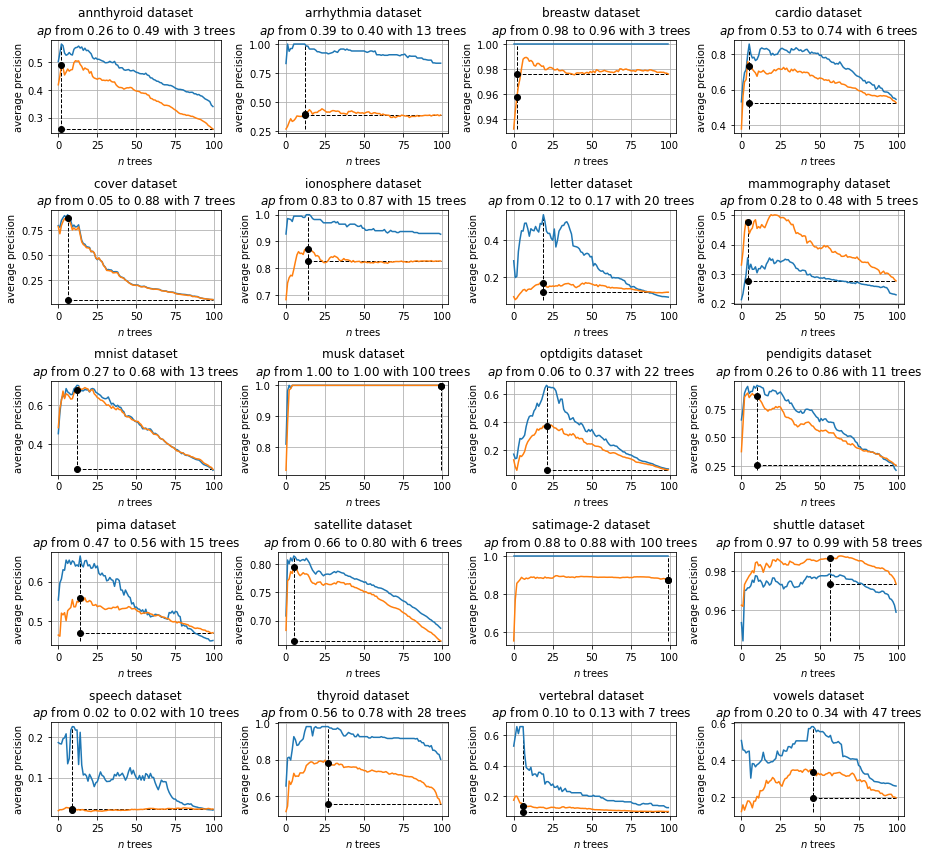

In [5]:
folder = '/Users/Tommaso/Documents/PythonCode/IsolationForest/sklearn-based/IFonaDiet/' 
supervised_size = 0.2
repetition      = 0

fig,axs = plt.subplots(5,4,figsize=[6.4/2*4,4.8/2*5])
axs = axs.flatten()

for i,filename in enumerate(['annthyroid', 'arrhythmia', 'breastw' ,'cardio' ,'cover', 'ionosphere',
 'letter', 'mammography', 'mnist' ,'musk' ,'optdigits' ,'pendigits', 'pima',
 'satellite', 'satimage-2' ,'shuttle' ,'speech' ,'thyroid', 'vertebral',
 'vowels']): #np.sort(glob.glob("/Users/Tommaso/Documents/PythonCode/Datasets/data/*.mat")):
    #name = os.path.basename(filename)
    
    #try:
    plot_one_run(axs[i],name,supervised_size,repetition,save='')

    plt.tight_layout()

    #except:
    #    print(name,'failed')